In [61]:
import numpy as np
from matplotlib import pyplot as plt
from SERSGenerator import SERSGenerator, pseudo_voigt

from tqdm import tqdm
from scipy.special import erfc, erfcinv
from scipy.stats import norm

from sklearn.decomposition import NMF
from matplotlib.ticker import MultipleLocator

In [62]:
def plot_map(gen, X, figsize=(8,8)):
    fig, axs = plt.subplots(2,2, figsize=figsize)

    # SERS Matrix
    axs[0,0].imshow(X, cmap='viridis', interpolation='none')
    axs[0,0].set_xlabel('Wavenumber')
    axs[0,0].set_ylabel('Spectrum index')
    axs[0,0].set_title('X')
    axs[0,0].grid(False)


    # Map at peak 1
    mappable = axs[0,1].imshow(X[:, int(round(gen.c[0]))].reshape(*gen.mapsize), cmap='viridis', interpolation='none')
    axs[0,1].set_title(f'c={round(gen.c[0])}')
    axs[0,1].grid(False)
    plt.colorbar(mappable=mappable, ax=axs[0,1])

    # One spectrum
    axs[1,0].plot(X[np.argmax(X)//gen.Nw,:])
    axs[1,0].set_xlabel('Wavenumber')
    axs[1,0].set_title('Highest spectrum')

    # Pure Voigt of peak 1
    axs[1,1].plot(gen.Vp[0,:])
    axs[1,1].set_xlabel('Wavenumber')
    axs[1,1].set_title('Pure Voigt 1')

    fig.tight_layout()
    plt.show()

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [64]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, train=True):
        """Initializes a dataset containing maps."""
        super().__init__()
        self.train = train
        N = X.shape[0]

        if self.train:
            start = 0
            end = int(round(0.8*N))
        else:
            start = int(round(0.8*N))
            end = N
        
        self.X = X[start:end, :, :]

    def __len__(self):
        """Returns the size of the dataset."""
        return self.X.shape[0]

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        item = self.X[index,:,:]
        return item

In [88]:
mapsize= (5,5)
N = mapsize[0]*mapsize[1]
W = 200

S = 1000
data = np.zeros((S, N, W))
for i in range(S):

    gen = SERSGenerator(mapsize=mapsize, Nw=W, eta=0)
    X = gen.generate(N_hotspots=2, K=1, sig=0.1, sbr=1, plot=False, background='none')
    data[i,:,:] = X
    # Track gen.c[0] - peak position?
    
data = data.astype('float32')

In [89]:
data_tensor = torch.from_numpy(data, )

trainset = MyDataset(data_tensor, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset = MyDataset(data_tensor, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=0)

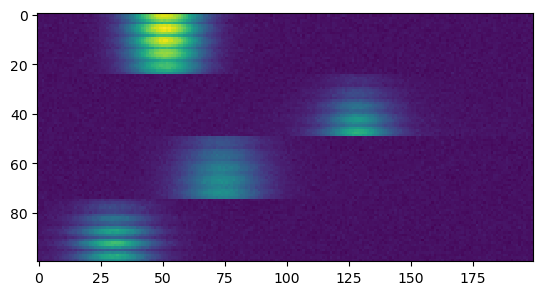

In [90]:
dataiter = iter(trainloader)
images = next(dataiter)
images = images.reshape(-1, W) # concatenate maps of width W below each other
plt.imshow(images, cmap='viridis', interpolation='none')
plt.show()

In [147]:
class Autoencoder(nn.Module):
    def __init__(self, N, W, hidden_dim):
        super(Autoencoder, self).__init__()
        
        self.N = N
        self.W = W
        input_dim = N*W
        latent_dim = N+W
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU(),
        )
        
    def decode(self, z):
        A = z[:, :self.N]
        B = z[:, self.N:]
        A = A.unsqueeze(-1)
        B = B.unsqueeze(1)
        res = torch.bmm(A, B)
        return res.view(-1, self.N*self.W)
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decode(z)
        return x_hat, z

Epoch [1/10], Loss: 0.0058
Epoch [2/10], Loss: 0.0044
Epoch [3/10], Loss: 0.0032
Epoch [4/10], Loss: 0.0026
Epoch [5/10], Loss: 0.0025
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0014
Epoch [9/10], Loss: 0.0013
Epoch [10/10], Loss: 0.0013


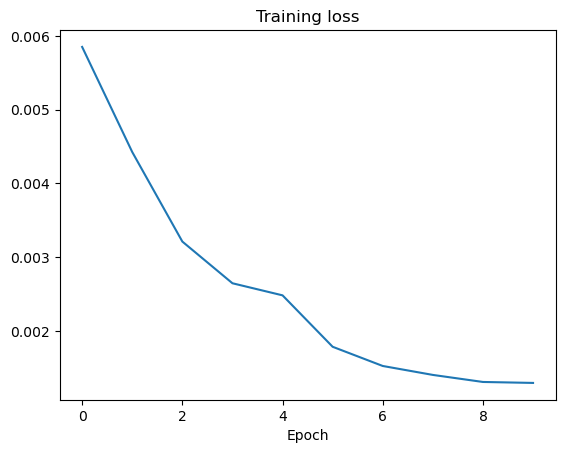

In [183]:
input_dim = N * W
hidden_dim = 512
latent_dim = N + W

# Create an instance of Autoencoder
autoencoder = Autoencoder(N, W, hidden_dim)

# Define optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
def train_autoencoder(autoencoder, optimizer, num_epochs, data_loader):
    autoencoder.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        
        batch_idx = 0
        for x in data_loader:
            x = x.view(-1, input_dim)
            optimizer.zero_grad()
            
            x_hat, z = autoencoder(x)
            loss = F.mse_loss(x_hat, x)
            
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        
            batch_idx += 1
    
        loss_list += [total_loss / len(data_loader.dataset)]
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_list[-1]))

    fig, ax = plt.subplots()
    ax.plot(loss_list)
    ax.set(title='Training loss', xlabel='Epoch')
    plt.show()

# Train the autoencoder
train_autoencoder(autoencoder, optimizer, num_epochs=10, data_loader=trainloader)

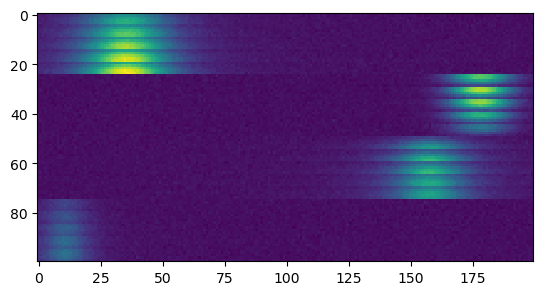

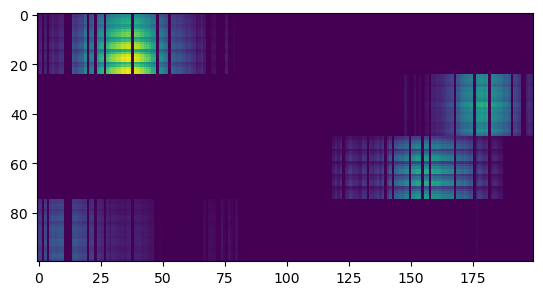

In [184]:
with torch.no_grad():
    for x in testloader:
        images = x
        images = images.reshape(-1, W) # concatenate maps of width W below each other
        plt.imshow(images, cmap='viridis', interpolation='none')
        plt.show()
           
        
        x = x.view(-1, input_dim)
        x_hat, z = autoencoder(x)
        x_hat = x_hat.view(-1, N, W)
        
        A = z[:, :N]
        B = z[:, N:]
        
        images = x_hat
        images = images.reshape(-1, W) # concatenate maps of width W below each other
        plt.imshow(images, cmap='viridis', interpolation='none')
        plt.show()
        break   

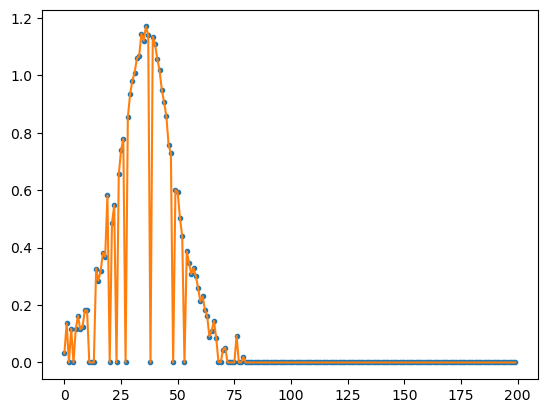

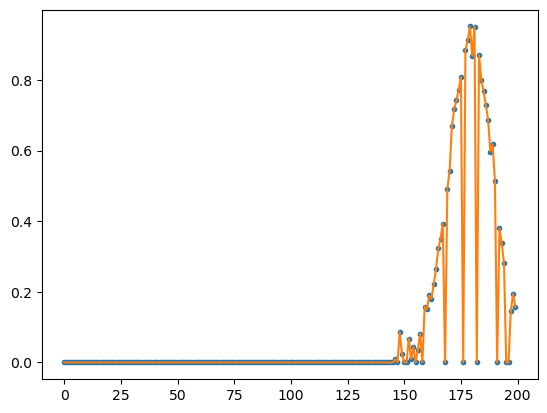

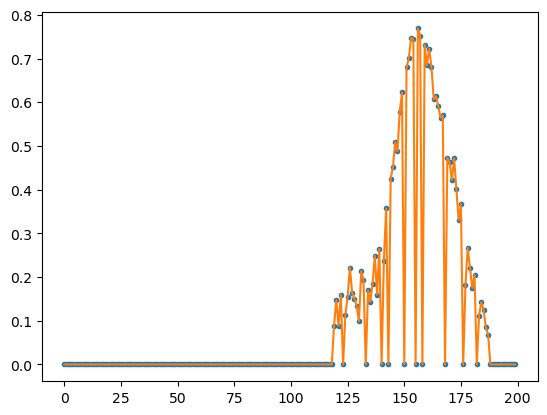

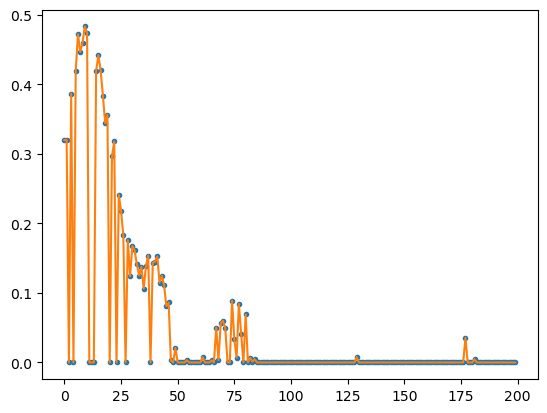

In [185]:
for i in range(4):
    plt.plot(B[i,:], ls=' ', marker='.')
    plt.plot(B[i,:])
    plt.show()